In [26]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

import rasterio as rst
from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.vrt import WarpedVRT
from rasterio.warp import calculate_default_transform, reproject, Resampling

from PIL import Image
import json

This notebook contains snippets for displaying geotiffs with user-chosen colours and for re-projecting raster data (geotiffs) into a different spatial projection for web display. The demo files from NCA Danny were in Australian Albers projection (EPSG:3577) and Mapbox needs 4326 (WGS84).If using something other than EPSG:4326, remember you will still need to reproject the PNG/geoJSON to that projection anyway as geoJSON is assumed to be in 4326 and will end up in the Pacific Ocean if you forget...

In [27]:
data_dir = r'G:\My Drive\3. Work\Sensand\raster-color-reprojection-snippets\0_originaldata'
output_dir = r'G:\My Drive\3. Work\Sensand\raster-color-reprojection-snippets\1_modifieddata'

color_bins = 3 #set number of discrete colours you want to pull from the color map
cmap_continuous = plt.get_cmap('viridis') #set the color map. Using viridis as a demo but any named color map from matplotlib can be set here
cmap_discrete = plt.get_cmap(cmap_continuous, color_bins)


src = rst.open(continuous_dir)

dst_crs = 'EPSG:4326' #double check with Zac if its 4326 or 3587. If it is 3587, will need to modify the PNG/geoJSON code to still export with 4326

print(src)
print(src.bounds)#Get geotiff bounding box (bbox) and CRS (coordinate reference system)
print(src.crs.to_proj4()) # the example from Danny is 3577 aka Australian Albers. This will need to be reprojected.
src.colorinterp[0] #this tells us that there is 1 band and its default color at the moment is greyscale
print(src.nodata)

<open DatasetReader name='G:/My Drive/3. Work/Sensand/raster-color-reprojection-snippets/0_originaldata/HL-Continous-Data.tif' mode='r'>
BoundingBox(left=1310114.552, bottom=-4682654.9304, right=1328464.552, top=-4667744.9304)
+init=epsg:3577
-3.3999999521443642e+38


From the rasterio documentation: Reprojecting a GeoTIFF dataset from one coordinate reference system is a common use case. Rasterio provides a few utilities to make this even easier:

transform_bounds() transforms the bounding coordinates of the source raster to the target coordinate reference system, densifiying points along the edges to account for non-linear transformations of the edges.

calculate_default_transform() transforms bounds to target coordinate system, calculates resolution if not provided, and returns destination transform and dimensions.

In [28]:
'''
this saves out a geotiff that is identical to the input one but in the new projection. 
It can either be coloured as part of this script, or deleted at the end.
'''
with rst.open(data_dir + "\\HL-Continous-Data.tif") as src2:
    # Get the transform and dimensions for the new dataset by copying from the original geotiff
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rst.open(output_dir + "\\HL-Continous-Data-reproject.tif", 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rst.band(src, i),
                destination=rst.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest) 

C:\Users\jenna\AppData\Local\Temp\ipykernel_8668\2111452106.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis', 10 )


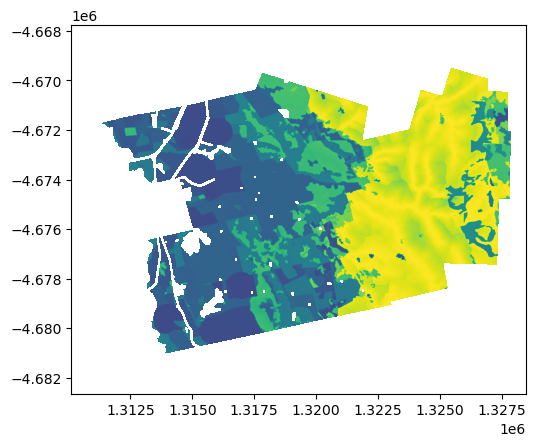

<Axes: >

In [29]:
#use matplotlib to get a color map we want to use. For testing I've gone with viridis
cmap=plt.cm.get_cmap('viridis', 10 )
show(src, transform=src.transform, cmap='viridis') #use this to see the image. This won't actually colour it though its just a preview

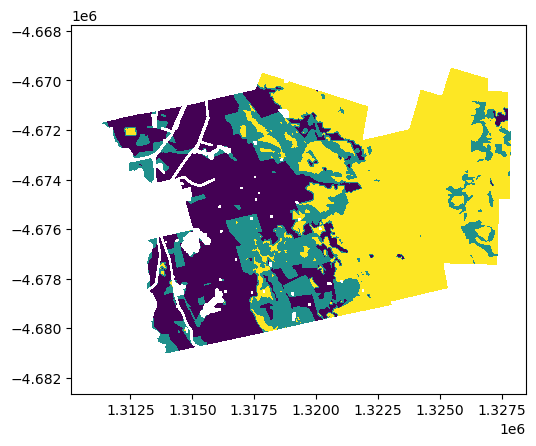

<Axes: >

In [30]:
bins = 3
cmap_discrete = plt.get_cmap('viridis', bins)
show(src, transform=src.transform, cmap=cmap_discrete)

In [31]:
'''
read the reprojected geotiff in, and then apply a colour map. 
Read the nodata value from the geotiff and use that to create an alpha mask so that the background is not coloured.
Save out as a geotiff
Also save out a PNG and a geojson of the bounding box, both derived from the geotiff
Note: long term it would probably make more sense to learn to do reprojections and coloring with VRT files.
But this will do for now for NCA.
'''
with rst.open(output_dir + "\\HL-Continous-Data-reproject.tif") as src:
    band1 = src.read(1)  # Read the first band
    nodata = src.nodata
    # Generate an alpha band (fully opaque where data is not nodata, fully transparent where it is)
    alpha_band = np.where(band1 == nodata, 0, 255).astype(np.uint8)

    normed_data = band1 / np.nanmax(band1)  # Normalize data to 0-1 range, assuming NaNs for nodata
    
    colored_data_continuous = (cmap_continuous(normed_data)[:, :, :3] * 255).astype(np.uint8) # RGBA to RGB and scaling to 0-255
    colored_data_with_alpha_continuous = np.dstack([colored_data_continuous, alpha_band]) # Merge RGB and alpha into a 4-band array (R, G, B, A)

    colored_data_discrete = (cmap_discrete(normed_data)[:, :, :3] * 255).astype(np.uint8) 
    colored_data_with_alpha_discrete = np.dstack([colored_data_discrete, alpha_band])
    
    # Prepare metadata for new GeoTIFF
    new_meta = src.meta.copy()
    new_meta.update({
        'count': 4,  # We're saving an RGB image, so 3 bands
        'dtype': 'uint8',  # Color data is in uint8 format
        'nodata': None  # Setting nodata value to None
    })
    
    # Write GeoTIFFs for continuous and discrete color maps
    with rst.open(output_dir + "\\HL-Continous-Data-reproject-col-continuous.tif", 'w', **new_meta) as dst:
        for k, arr in enumerate([colored_data_with_alpha_continuous[:, :, i] for i in range(colored_data_with_alpha_continuous.shape[2])], 1):
            dst.write(arr, indexes=k)

    with rst.open(output_dir + "\\HL-Continous-Data-reproject-col-discrete.tif", 'w', **new_meta) as dst:
        for k, arr in enumerate([colored_data_with_alpha_discrete[:, :, i] for i in range(colored_data_with_alpha_discrete.shape[2])], 1):
            dst.write(arr, indexes=k)
            
    # Read bounding box and CRS for GeoJSON
    bbox = src.bounds
    crs = src.crs.to_string()

# Generate PNG from GeoTIFFs
image = Image.fromarray(colored_data_with_alpha_continuous, 'RGBA')
png_output_path = output_dir + "\\HL-Continous-Data-reproject-col-continuous.png"  # Replace with your desired PNG output path
image.save(png_output_path)

image = Image.fromarray(colored_data_with_alpha_discrete, 'RGBA')
png_output_path = output_dir + "\\HL-Continous-Data-reproject-col-discrete.png"  # Replace with your desired PNG output path
image.save(png_output_path)

# Generate GeoJSON for bounding box
bbox_geojson = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [bbox.left, bbox.bottom],
                [bbox.left, bbox.top],
                [bbox.right, bbox.top],
                [bbox.right, bbox.bottom],
                [bbox.left, bbox.bottom]
            ]
        ]
    },
    "properties": {
        "crs": crs
    }
}

geojson_output_path = output_dir + "\\HL-Continous-Data-reproject-3587-bbox.geojson"  # Replace with your desired GeoJSON output path
with open(geojson_output_path, 'w') as f:
    json.dump(bbox_geojson, f)

print("GeoTIFF, PNG, and GeoJSON generation complete.")

c:\Users\jenna\anaconda3\envs\specdal\lib\site-packages\matplotlib\colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


GeoTIFF, PNG, and GeoJSON generation complete.
